# A proof for not relying on public score

Hi all, 

The purpose of this notebook is to show you why you should not rely only on the public score you get when you submit a notebook.

Market forecasting is a very difficult task, and don't expect simple models to outperform the market: if it was so easy, everybody would do it :) 

Because of the high-volatility and the high randomness of the task, it will be really, really simple to overfit the public LB: any little change in your code can give you dramatically different results, and seeing improvments in the LB score can give you the illusion of making progress, while you are just picking up the best "random" solution.

And indeed: we need to accept that pure randomness is playing a high role here. Carl McBride Ellis showed in this notebook: https://www.kaggle.com/code/carlmcbrideellis/jpx-are-my-monkeys-normal that it is not unlikely that a simple random picker performs well on a short time window, as shown by the distribution of scores of random pickers below:

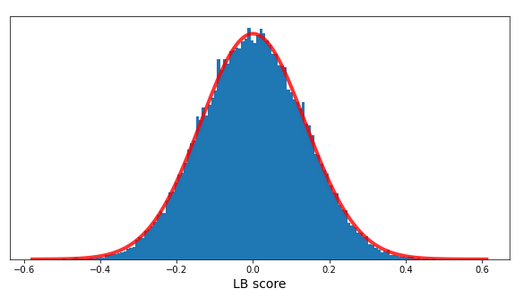


As the evaluation window is very small, we should make sure to validate our strategy on a larger sample of data and being rigourous in the backtesting. 

I will split this Notebook in two part. 

In part I, I will extend the work of Carl by trying to find what time window would be sufficient for the evaluation of the sharp ratio. 
In part II, I will take the example of a simple strategy that looks good when evaluated in the public LB, but that doesn't show robusness when evaluated on a larger time window.

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

def calc_return(X,targets):
    '''My home made function to do the weighted score'''
    longs = X<200
    longs = ((1-(X/199))+1)*longs/600
    shorts = X>1799
    shorts = -((X-1800)/199+1)*shorts/600
    return (targets*(shorts+longs)).sum(axis=1)

# Part I - The return of the monkeys

Quoted again Carl's notebook https://www.kaggle.com/code/carlmcbrideellis/jpx-are-my-monkeys-normal, he demonstrated that the probability of reaching a good sharp value based on pure random picker is far from being negligible. 

In this part, I reproduce his work on the public LB, and try to extend it to larger time-windows to see how it impacts the probability of reaching high sharp scores by pure randomness

In [ ]:
POP_SIZE = 10000

df1 = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
df2 = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv')
df = pd.concat([df1,df2])
df.Date = pd.to_datetime(df.Date)
targets = pd.pivot_table(df, values = "Target", index = "Date", columns = "SecuritiesCode")

targets.tail()

## Evaluation on the LB Window

In [ ]:
lbtargets = targets.loc[df2.Date.iloc[0]:df2.Date.iloc[-1]]

strats_scores = []
for _ in tqdm(range(POP_SIZE)):
    # Create random value for each day, and each column of the test set
    probas = np.random.random(lbtargets.shape)
    
    # Create a random ranking
    rank = np.argsort(probas)
    
    # Evaluation of the return each day
    score = calc_return(rank, lbtargets)
    
    # Adding the sharp ratio of the strategy
    strats_scores.append(score.mean()/score.std())
    
strats_scores = np.array(strats_scores)

By checking the distribution of our simulation, we find the same results as Carl, confirming the high chance of a random picker to perform well in the public LB.

In [ ]:
plt.figure(figsize = (12,5))
plt.title("distribution of scores of the random pickers")
plt.hist(strats_scores, bins = 100)
plt.show()

print(f"Probability to reach 0.1: {len(strats_scores[strats_scores>=0.1])/POP_SIZE}")
print(f"Probability to reach 0.2: {len(strats_scores[strats_scores>=0.2])/POP_SIZE}")

print(f"Quantile score 0.90: {round(np.quantile(strats_scores, 0.90),3)}")

Note that a daily sharp value of 0.1 is supposively already a very good theoretical sharp value.

In [ ]:
WINDOWS = [120,180,365,365*2]
random_quantiles = [np.quantile(strats_scores, 0.90)]
for window in WINDOWS:
    
    #Now the targets will depend on the window size
    lbtargets = targets.iloc[-window:]

    strats_scores = []
    for _ in tqdm(range(POP_SIZE)):
        # Create random value for each day, and each column of the test set
        probas = np.random.random(lbtargets.shape)

        # Create a random ranking
        rank = np.argsort(probas)

        # Evaluation of the return each day
        score = calc_return(rank, lbtargets)

        # Adding the sharp ratio of the strategy
        strats_scores.append(score.mean()/score.std())

    strats_scores = np.array(strats_scores)    
    
    random_quantiles.append(np.quantile(strats_scores, 0.9))
    
WINDOWS = [56] + WINDOWS

In [ ]:
fig = go.Figure(
    go.Scatter(
        x = WINDOWS,
        y = random_quantiles,
        name = "sharp quantile 0.9"
    )
)

fig.add_trace(
    go.Scatter(
        x = WINDOWS,
        y = np.ones(len(WINDOWS))*0.062,
        marker = {"color":"red"},
        mode = "lines",
        name = "Yearly sharp = 1"
    )
)
fig.update_layout(template="presentation", title = "top 10% score of the random pickers, vs test window")
fig.update_yaxes(title = "Daily sharp score", range = (0,0.2))
fig.update_xaxes(title = "Window size (days)")
fig.show()

## Part II: An example of what you should not do

In part two, my objective will be to illustrate the part of luck with an actual example about what you should not do.

I'll take an example of training a simple LGBRegressor on the raw stock prices that I saw in many public notebooks to illustrate my argument. 

## Training a Regressor on training data only

In [ ]:
feature_cols = ["Date", "SecuritiesCode", "Open", "High", "Low", "Close", "Volume"]
X = df1[feature_cols]
X.Date = pd.to_datetime(X.Date).astype(int)
y = df1["Target"]

lgb_params = {
    "objective": "regression",
    'metric': 'rmse',
    "n_estimators" : 200,
    "num_leaves" : 60,
    "learning_rate" : 0.1,
    "random_seed" : 10}

lgb = LGBMRegressor(**lgb_params)
lgb.fit(X,y)

## Backtesting on public test data

Note that there is no leakage introduced here as the backtest is performed on a time window never seen by my model.

In [ ]:
Xtest = df2[feature_cols]
Xtest.Date = pd.to_datetime(Xtest.Date).astype(int)

#Calculate the predictions for the whold test data
preds = lgb.predict(Xtest)
df2["preds"] = preds
#Pivot the preds to prepare for the daily ranking
predpiv = pd.pivot_table(df2, values = "preds", index = "Date", columns ="SecuritiesCode")

#Rank the preds
ranks = 1999-np.argsort(np.argsort(predpiv))

#Targets, used to calculate the score of the benchmark
targets_test = pd.pivot_table(df2, values = "Target", index = "Date", columns ="SecuritiesCode")

daily_return = calc_return(ranks, targets_test)

In [ ]:
fig = go.Figure(
    go.Scatter(
        x = daily_return.index,
        y = daily_return.cumsum()
    )
)

fig.update_layout(template = "presentation", title = f"Cumulative return of the strategy, score = {np.round(daily_return.mean()/daily_return.std(),3)}")
fig.show()

Looking at the graph above, the strategy looks very good and super efficient, with a high sharp ratio of 0.236 !

Nethertheless, according to part I, almost 10% of random pickers could reach such a perfomance on that time window... So how to really confirm its validity ?

## Performing a benchmark on a larger test window

Instead of training the model on the whole data, I will simply train it on everything before 2020. That will leave us 2 full year to evaluate the model. Even if we use less labels for training, we should not expect to see big variations if we are actually extracting meaningfull values.

In [ ]:
start_test = "2020-01-01"
WINDOW_TEST = 56
return_tot = []
while True:
    #Not adding comments here, but i'm basically doing exactly as before apart from the test window
    X = df.reset_index()[feature_cols]
    X.Date = pd.to_datetime(X.Date)
    y = df.reset_index()["Target"]

    Xtrain = X.loc[X.Date<start_test]
    
    #We are going to evaluate only on the next 90 days, to make sure we learn things relatively close to the test window
    Xtest = X.loc[(X.Date>=start_test) & (X.Date<=pd.to_datetime(start_test)+pd.offsets.Day(WINDOW_TEST))]
    ytrain = y.loc[Xtrain.index]
    ytest = y.loc[Xtest.index]

    Xtrain.Date = Xtrain.Date.astype(int)
    Xtest.Date = Xtest.Date.astype(int)

    lgb = LGBMRegressor(**lgb_params)
    lgb.fit(Xtrain,ytrain)

    p = lgb.predict(Xtest)
    Xtest["preds"] = p
    predpiv = pd.pivot_table(Xtest, values = "preds", index = "Date", columns ="SecuritiesCode")
    predpiv.index = pd.to_datetime(predpiv.index)
    targets_test = pd.pivot_table(df.reset_index().loc[Xtest.index], values = "Target", index = "Date", columns ="SecuritiesCode")

    ranks = 1999-np.argsort(np.argsort(predpiv))
    daily_return = calc_return(ranks, targets_test)
    return_tot.append(daily_return)
    
    start_test = daily_return.index[-1]+pd.offsets.Day(1)
    if start_test >= pd.to_datetime(df.Date.iloc[-1]):
        break
        
return_tot = pd.concat(return_tot)

Whoops... Not very conclusif at the end.. The score is here 10 times lower, and we can see clearly that the public LB high score could have just been a "lucky shot"

In [ ]:
fig = go.Figure(
    go.Scatter(
        x = return_tot.index,
        y = return_tot.cumsum()
    )
)

fig.update_layout(template = "presentation", title = f"Cumulative return of the strategy, score = {np.round(return_tot.mean()/return_tot.std(),3)}")
fig.show()

# Conclusion

If you arrived here, thanks for reading, and I hope the notebook will help improving your backtesting strategy.
Please don't hesitate to leave a comment if you have questions or suggestions on my code.